# ReACT with massive neutrinos

For the following example you need the Pyhton wrapper for CAMB installed. The easiest way to do this is to use the `conda` package:

`conda install camb -c conda-forge`

We will look at an example of quintessence with massive neutrinos. 

If you want to have modified gravity such as f(R) or DGP with massive neutrinos you will need a wrapper for the associated boltzmann code, or work in developer mode and use the example files in reactions/examples. 

In [1]:
import numpy as np
import camb 

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact
#print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

from scipy.interpolate import CubicSpline

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
Omega_c = 0.2598
Omega_b = 0.0482
h = 0.678
n_s = 0.966 
A_s = 2.112e-9

# Model selection and parameter (1:GR, 2:f(R), 3:DGP, 4:quintessence , 5:CPL )
mymodel = "quintessence"
w0 = -0.9
w_a = 0.0
# set mass of massive neutrino species 
m_nu = 0.2
Omega_nu = m_nu/93.14/h**2
# Loop in spherical collapse 
massloop = 30

Omega_m = Omega_c + Omega_b + Omega_nu

In [3]:
# Run CAMB for target cosmology (quintessence) and for LCDM.
p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False, DarkEnergyModel="fluid")
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)


p.set_matter_power(redshifts=np.linspace(0.0, 1.0, 2, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

#We will consider redshifts 0.0 and 1.0
r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]

# power spectra needed for input (total matter and CDM+baryons) - alternatively one can use the transfer functions
#the matter power spectrum (will be used for a consistency test)
k_lin, z_lin, pofk_lin_camb_tot = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=256,
                                                              var1='delta_tot',var2='delta_tot')
k_lin, z_lin, pofk_lin_camb_cb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=256,
                                                             var1= 'delta_nonu',var2='delta_nonu')


In [4]:
# Get CB spectrum for LCDM 
p_lcdm = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False, DarkEnergyModel="fluid")
    
p_lcdm.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p_lcdm.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p_lcdm.set_dark_energy(w=-1.0,wa=0.0)

p_lcdm.set_matter_power(redshifts=np.linspace(0.0, 1.0, 2, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

r_lcdm = camb.get_results(p_lcdm)
sigma_8_lcdm = r_lcdm.get_sigma8()[-1]

# power spectra needed for input (total matter and CDM+baryons) - alternatively one can use the transfer functions
#the matter power spectrum (will be used for a consistency test)
k_lin_lcdm, z_lin, pofk_lin_camb_lcdm_cb = r_lcdm.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=256,
                                                              var1='delta_nonu',var2='delta_nonu')


Now run ReACT to get the reaction (and the modified linear power spectrum) 

In [5]:
react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]

 
R0, pofk_lin_mod_react0, sigma_8_mod = react.compute_reaction_nu(
                                h, n_s, Omega_m, Omega_b, Omega_nu, A_s, 
                                z_react, k_lin, pofk_lin_camb_tot.flatten(), pofk_lin_camb_cb.flatten(),
                                k_lin_lcdm, pofk_lin_camb_lcdm_cb.flatten(), 
                                pscale = 0.05,
                                model=mymodel, 
                                fR0=0., Omega_rc=0, w=w0, wa=0, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  


In [6]:
sigma_8_mod/sigma_8

1.0001380925047498

Now plot the reaction and matter spectrum as a consistency check 

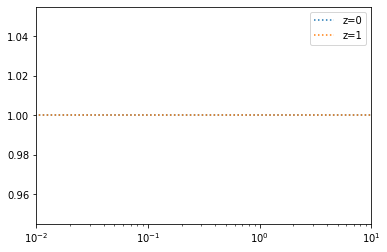

In [8]:
plt.semilogx(k_lin, pofk_lin_mod_react0[0]/pofk_lin_camb_tot[0],linestyle='dotted',label='z=0')
plt.semilogx(k_lin, pofk_lin_mod_react0[1]/pofk_lin_camb_tot[1],linestyle='dotted',label='z=1')

plt.xlim([1e-2,10])
#plt.ylim([0.99,1.1])

plt.legend()

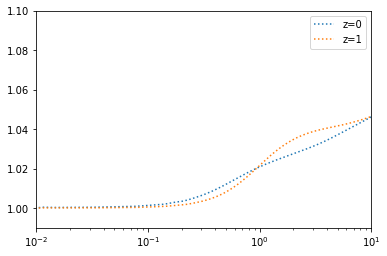

In [9]:
plt.semilogx(k_lin, R0[0],linestyle='dotted',label='z=0')
plt.semilogx(k_lin, R0[1],linestyle='dotted',label='z=1')

plt.xlim([1e-2,10])
plt.ylim([0.99,1.1])

plt.legend()